# QSAR modelling of estrogen receptor alpha ligands

This notebook features a workflow that tries to extract activity-structure information from experimental data. 


## Data Aquisition and Preprocessing

The data are saved in the database (DB) and can be loaded into a [pandas](http://pandas.pydata.org) data frame using the [`compound_db_utils`](https://github.com/martin-sicho/MI_ADM/tree/master/compound_db_utils) package:

In [1]:
import os, pickle, math

from compound_db_utils import settings
from compound_db_utils.data_loaders import fetch_learning_data

SEED = 42
RELOAD = False # if True, ignore the pickled data and update from DB

def remove_inconsistent(smiles, ic50s):
    """
    Filter that computes a consensus value for molecules that were tested
    multiple times. The consensus is computed as the median of all 
    available values. 
    
    Molecules with too much variation in the data 
    and too few data points are marked as inconsistent and
    removed entirely.
    """
    
    if int(math.log(ic50s.min(), 10)) != int(math.log(ic50s.max(), 10)) and len(ic50s) < 20:
        return False
    else:
        return ic50s.median()

data = None
if os.path.exists('data.pickle') and not RELOAD:
    data = pickle.load(open('data.pickle', 'br'))
else:
    data = fetch_learning_data(
                ['MI-T-15c25ba4']
                , col_names_map={
                    settings.COMPOUNDS_TABLE + '_smiles' : 'smiles'
                    , settings.BIOACTIVITIES_TABLE + '_value' : 'ic50'
                }
                , create_rdkit_mols=False
                , compute_descriptors=True
                , duplicates_handler= remove_inconsistent
            )
    
pickle.dump(data, open('data.pickle', 'bw'))    

/home/sichom/software/miniconda/envs/MI_ADM/lib/python3.5/site-packages/rdkit/Chem/PeriodicTable.py:131: FutureWarning: split() requires a non-empty pattern match.
  splitLine = blankExpr.split(line)


For each compound, the loaded data provide the canonical [SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) string and measured [IC50](https://en.wikipedia.org/wiki/IC50) values. We also chose to compute molecular descriptors for the compounds. Those are saved in the remaining columns (descriptors are computed using the [RDKit](https://rdkit.readthedocs.io/en/latest/) cheminformatics toolkit).

Note that the original dataset may contain duplicate entries, because more experiments were often carried out for one given compound. Here, we decided to remove compounds that show large inconsistencies in their IC50 values and we do not have enough data to safely aggregate the values together.

Because now we only have one SMILES string for each compound, we can use them as the index of the data frame:

In [2]:
# data.set_index('smiles', inplace=True)
print(data.shape)
data.head(10)

(1327, 198)


,ic50,smiles,MaxAbsPartialCharge,MaxAbsEStateIndex,MinPartialCharge,NumValenceElectrons,MaxPartialCharge,MinAbsPartialCharge,MinEStateIndex,ExactMolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,31.055,CC(C)c1cccc(N2CCc3cc(O)ccc3C2(C)c2ccc(OCCN3CCCCC3)cc2)c1,0.507956,10.188795,-0.507956,190,0.118883,0.118883,-0.357919,484.308979,...,0,0,0,0,0,0,0,0,0,0
2,4.700,CCc1c(O)ccc2c1O[C@H](c1ccc(OCCN3CCCCC3)cc1)[C@H](c1ccc(O)cc1)S2,0.507967,10.412779,-0.507967,184,0.140270,0.140270,-0.243942,491.213030,...,1,0,0,0,0,0,0,0,0,0
3,24.800,Cc1ccc(S(=O)(=O)N2CCc3cc(O)ccc3C2c2ccc(OCCN3CCCC3)cc2)cc1,0.507956,13.740342,-0.507956,184,0.243451,0.243451,-3.728670,492.208279,...,0,1,0,0,0,0,0,0,0,0
4,6.000,CC1=C(c2ccc(O)cc2)C(=O)c2ccc(O)cc21,0.507966,12.401821,-0.507966,94,0.194032,0.194032,-0.043343,252.078644,...,0,0,0,0,0,0,0,0,0,0
5,35.000,Oc1ccc2c(c1)S[C@H](c1ccco1)[C@H](c1ccc(OCCN3CCCCC3)cc1)O2,0.507920,9.863330,-0.507920,162,0.143093,0.143093,-0.198525,437.166079,...,1,0,0,0,0,0,0,0,0,0
8,1260.000,O=c1c2oc3c(Br)cc(O)cc3c2oc2cc(O)cc(O)c12,0.507895,12.512773,-0.507895,110,0.239157,0.239157,-0.558945,361.942600,...,0,0,0,0,0,0,0,0,0,0
9,1727.000,Oc1ccc2c(-c3cccc4ccc(O)cc34)noc2c1,0.507943,9.724977,-0.507943,102,0.170701,0.170701,0.139596,277.073893,...,0,0,0,0,0,0,0,0,0,0
10,114.000,Cc1cc(O)cc2cc(-c3ccc(O)cc3)oc12,0.507966,9.552571,-0.507966,90,0.137489,0.137489,0.225635,240.078644,...,0,0,0,0,0,0,0,0,0,0
11,527.000,C=Cc1cc(O)cc2ccc(-c3ccc(O)c(F)c3)cc12,0.507921,13.477906,-0.507921,104,0.164917,0.164917,-0.650697,280.089958,...,0,0,0,0,0,0,0,0,0,0
12,2.200,OCC1CCN(CCOc2ccc([C@@H]3Oc4ccc(O)cc4S[C@@H]3c3ccc(O)cc3)cc2)CC1,0.507967,9.943080,-0.507967,184,0.140005,0.140005,-0.232911,493.192294,...,1,0,0,0,0,0,0,0,0,0


Next, we convert the IC50 values to pIC50 which is defined as the negative logarithm with base 10 of the concentration in moles rather than nanomoles (the default unit for the data in our database): 

In [3]:
import numpy as np

data.ic50 = data.ic50.apply(lambda x : -1.0 * np.log10(x / 1.0e9))

Because of the logarithmic scale, the converted data are now much 'nicer' (note that the higher the pIC50 value, the more potent the compound is as opposed to the raw IC50 value where lower value means higher potency):

Original:
count       1327.000000
mean       12345.786545
std       126395.212707
min            0.200000
25%           55.500000
50%          625.000000
75%         7308.305000
max      3500000.000000
Name: ic50, dtype: float64

Converted:
count    1327.000000
mean        6.295696
std         1.359669
min         2.455932
25%         5.136184
50%         6.204120
75%         7.255725
max         9.698970
Name: ic50, dtype: float64


[]

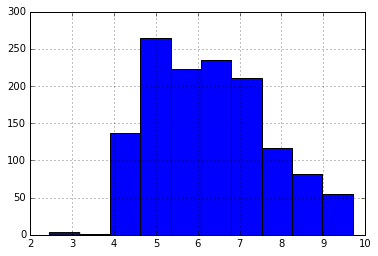

In [4]:
%matplotlib inline
print('Original:')
print(data.ic50.apply(lambda x : np.power(10, - x) * 1.0e9).describe())
print('\nConverted:')
print(data.ic50.describe())
data.ic50.hist().plot()

## Model Building

Now that the dataset is ready, we split the data frame into a training and testing set:

In [5]:
from sklearn.cross_validation import train_test_split

data_train, data_test, pIC50_train, pIC50_test = train_test_split(
    data
    , data.ic50
    , test_size=0.4
    , random_state=SEED
)
data_train.smiles.head()

174                      CN(CCCc1ccc(F)cc1)c1nc(NCCc2ccc(O)cc2)nc(N2CCNCC2)n1
1454    Cc1ccccc1C(=O)N1CCN(c2ccc(C(=O)c3c(-c4ccc(O)cc4)sc4cc(O)ccc34)cc2)CC1
92                   CCOP(=O)(OCC)C1(NS(=O)(=O)c2ccccc2)C=C(Cl)C(=O)c2ccccc21
1599                                      CCC1Oc2c(ccc(O)c2C)-c2c(C)cc(O)cc21
320                                    Oc1ccc(-c2nn(C3CCCC3)c3c(Cl)cccc23)cc1
Name: smiles, dtype: object

In this experiment, we will be using [h2o](http://www.h2o.ai/) for Python to build the model. Therefore, we initialize the `h2o` module and upload our data to the H2O cluster:

In [6]:
import h2o

from h2o.frame import H2OFrame

h2o.init()
h2o.h2o.remove_all()

def create_frame(data, name):
    frame = H2OFrame.from_python(
        python_obj=data
        , destination_frame=name
        , column_names=data.columns.get_values().tolist()
        , header=1
    )
    return frame

training_frame = create_frame(data_train, "training_frame")
testing_frame = create_frame(data_test, "testing_frame")
print(training_frame.shape, testing_frame.shape)

Connecting to H2O server at http://localhost:54321... successful!


H2O cluster uptime:,1 hour 6 mins
H2O cluster version:,3.10.0.3
H2O cluster version age:,2 days
H2O cluster name:,sichom
H2O cluster total nodes:,1
H2O cluster free memory:,1.398 Gb
H2O cluster total cores:,2
H2O cluster allowed cores:,2
H2O cluster is healthy:,True
H2O cluster is locked:,True
H2O connection url:,http://localhost:54321




(796, 198) (531, 198)


and we train a Random Forest Estimator on the training set:

In [7]:
# from h2o.estimators.random_forest import H2ORandomForestEstimator as RFE

# model = RFE(
#     model_id = "random_forest_model"
# #      , mtries=-1
# #      , sample_rate=0.666
# #      , sample_rate_per_class=[]
# #      , col_sample_rate_per_tree=1
# #      , col_sample_rate_change_per_level=1
# #      , build_tree_one_node=False
# #      , ntrees=50
# #      , max_depth=20
# #      , min_rows=1
# #      , nbins=20
# #      , nbins_cats=1024
# #      , binomial_double_trees=False
# #      , balance_classes=False
#      , seed=SEED
#      , nfolds=5
#      , fold_assignment="Random"
# #      , keep_cross_validation_predictions=False
# #      , keep_cross_validation_fold_assignment=False
# #      , score_each_iteration=False
# #      , score_tree_interval=0
# #      , stopping_rounds=0
# #      , stopping_metric="AUTO"
# #      , stopping_tolerance=0.001
# #      , min_split_improvement=0
# #      , histogram_type="AUTO"
# )
# model.train(
#     x=training_frame.names[2:]
#     , y='ic50'
#     , training_frame=training_frame
# )
# # model.show()

In [8]:
from h2o.grid.grid_search import H2OGridSearch
from h2o.estimators.random_forest import H2ORandomForestEstimator as RFE

parameters = {
    'ntrees' : [10, 50, 100, 150, 200]
    , 'max_depth' : [2, 4, 6, 8, 10, 20, 30]
    , 'col_sample_rate_per_tree' : [0.3, 0.6, 1.0]
    , 'stopping_rounds' : [0, 2, 4]
}
search_criteria = { 
    'strategy': "RandomDiscrete"
    , 'seed': SEED
    , 'stopping_metric': "MSE"
    , 'stopping_tolerance': 0.01
    , 'stopping_rounds': 5
}
grid_search = H2OGridSearch(
    RFE(
        seed=SEED
        , nfolds=10
    )
    , grid_id='grid_search'
    , hyper_params=parameters
    , search_criteria=search_criteria
)
grid_search.train(
    x=training_frame.names[2:]
    , y='ic50'
    , training_frame=training_frame
)
grid_search_results = grid_search.sort_by('r2', False)
best_model_id = grid_search_results['Model Id'][0]
best_model = h2o.get_model(best_model_id)
model = best_model
print(grid_search_results)
print(grid_search.get_hyperparams(best_model_id))



Grid Search Results for H2ORandomForestEstimator: 


Model Id,"Hyperparameters: [max_depth, col_sample_rate_per_tree, ntrees, stopping_rounds]",r2
grid_search_model_23,"[10, 0.3, 200, 0]",0.7441238
grid_search_model_26,"[10, 1.0, 200, 4]",0.7426792
grid_search_model_9,"[20, 0.3, 150, 0]",0.7412594
grid_search_model_21,"[8, 0.6, 200, 0]",0.7405337
grid_search_model_0,"[20, 1.0, 150, 4]",0.7398425
---,---,---
grid_search_model_18,"[2, 0.6, 150, 4]",0.5883258
grid_search_model_11,"[2, 1.0, 100, 4]",0.5845137
grid_search_model_3,"[2, 0.3, 50, 4]",0.5793294
grid_search_model_19,"[2, 1.0, 10, 0]",0.5775673



See the whole table with table.as_data_frame()

Hyperparameters: [max_depth, col_sample_rate_per_tree, ntrees, stopping_rounds]
[10, 0.3, 200, 0]


In [10]:
importances = model.varimp(use_pandas=True)
pickle.dump(importances, open('importances_rf.pickle', 'bw'))
importances.head()

,variable,relative_importance,scaled_importance,percentage
0,MinPartialCharge,32451.550781,1.000000,0.149674
1,MaxAbsPartialCharge,22401.525391,0.690307,0.103321
2,MolLogP,17204.501953,0.530160,0.079351
3,MolMR,10233.962891,0.315361,0.047201
4,fr_benzene,6195.009277,0.190900,0.028573


### Cross-validation Results

In [11]:
performance = model.model_performance(xval=True)
print("R^2:", performance.r2())
print("R:", math.sqrt(performance.r2()))
print("MSE:", performance.mse())

R^2: 0.7310180192662594
R: 0.8549959176898212
MSE: 0.5134650301028894


### Validation Set Results

In [12]:
performance = model.model_performance(test_data=testing_frame)
print("R^2:", performance.r2())
print("R:", math.sqrt(performance.r2()))
print("MSE:", performance.mse())

R^2: 0.5410208146939071
R: 0.7355411713112374
MSE: 0.8019793476803535


### Error plots

Finally, we take a look at the distribution of errors in predictions among the training set and the test set. We fetch and save the required data first:

In [13]:
from pandas import DataFrame

predictions_train = model.predict(training_frame).as_data_frame()
predictions_test = model.predict(testing_frame).as_data_frame()
predictions_train.columns = ['ic50']
predictions_test.columns = ['ic50']
true_values_train = training_frame['ic50'].as_data_frame()
true_values_test = testing_frame['ic50'].as_data_frame()

validation_predictions = DataFrame()
validation_predictions['ic50_predicted'] = predictions_test['ic50']
validation_predictions['ic50_true'] = true_values_test
validation_predictions.index = data_test.smiles
pickle.dump(validation_predictions, open('validation_set_predictions_rf.pickle', 'wb'))
validation_predictions.head()

,ic50_predicted,ic50_true
smiles,,
Oc1ccc(-c2nc3cc(O)cc(-c4cccs4)c3o2)cc1,6.200982,5.987163
Oc1ccc2c(c1)CCN(c1ccccc1)C2c1cccs1,6.341957,7.301030
Oc1cccc(C2=Cc3ccc(O)cc3C23Cc2ccccc2C3)c1,6.547599,7.508638
C[C@@H](COc1ccc([C@@H]2Oc3ccc(O)cc3S[C@@H]2c2ccc(O)cc2)cc1)N1CC[C@@H](C)C1,7.719436,8.886057
O=C(Nc1ccc2c(c1)nc1n2CCSC1)c1ccco1,5.057493,4.838441


and then construct the error plot:

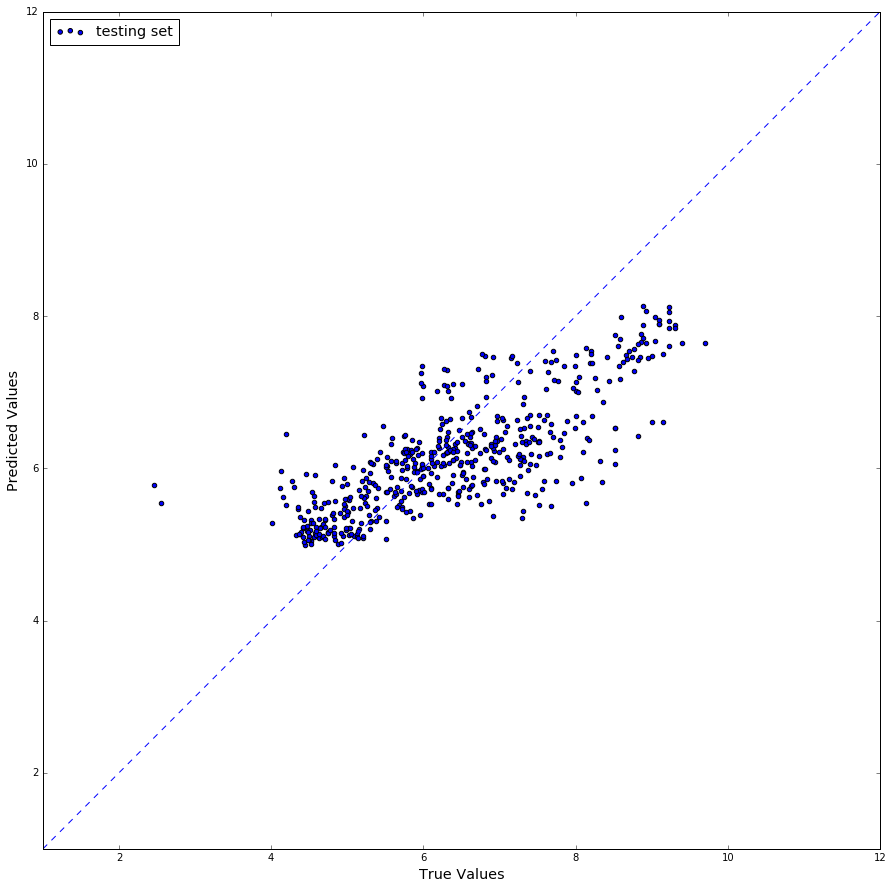

In [14]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [15, 15]
span = (1,12)
axes = plt.gca()
axes.set_xlim(span)
axes.set_ylim(span)
axes.set_xlabel("True Values", fontsize='x-large')
axes.set_ylabel("Predicted Values", fontsize='x-large')

plt.plot((span[0],span[1]), (span[0],span[1]), linestyle='--')

# plt.scatter(
#     true_values_train
#     , predictions_train
#     , c='green'
#     , s=20
#     , label='training set'
# )

plt.scatter(
    true_values_test
    , predictions_test
    , c='blue'
    , s=20
    , label='testing set'
)

plt.legend(loc='upper left', fontsize='x-large')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb35add6ba8>]], dtype=object)

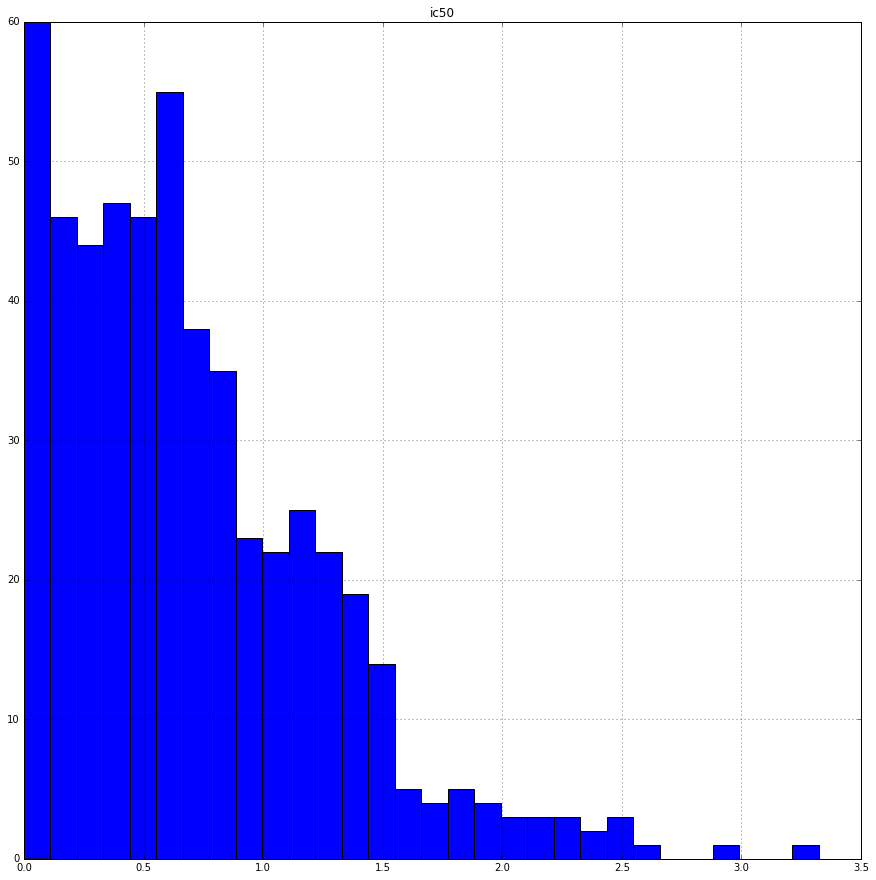

In [15]:
(true_values_test - predictions_test).abs().hist(bins=30)

## PCA Analysis

We can extract features that proved to be of high importance in the decision tree building, thus, should be most relevant to the activity-structure relationship. and project the molecules to 3D space and see if there is any correlation between their postion and the pIC50 value:

In [16]:
importances = model.varimp(use_pandas=True)
mask = (importances["scaled_importance"] * 100) > 5
descs_important = data[importances["variable"][mask]]
print(descs_important.shape)
descs_important.head(10)

(1327, 35)


,MinPartialCharge,MaxAbsPartialCharge,MolLogP,MolMR,fr_benzene,BalabanJ,fr_NH1,Chi1v,NumAromaticCarbocycles,Chi4n,...,SMR_VSA9,SlogP_VSA11,SlogP_VSA5,MinEStateIndex,Kappa2,PEOE_VSA3,LabuteASA,Chi0v,PEOE_VSA7,EState_VSA5
0,-0.507956,0.507956,6.70650,148.3698,3,1.436100,0,13.606228,3,5.964871,...,11.499024,11.499024,68.205388,-0.357919,10.558343,0.000000,216.070565,22.042053,103.845629,60.293170
2,-0.507967,0.507967,6.49200,139.7866,3,1.368494,0,13.422764,3,4.925974,...,22.998047,22.998047,54.230461,-0.243942,10.835690,0.000000,211.246794,20.967940,79.877083,32.351978
3,-0.507956,0.507956,4.51162,136.3356,3,1.434939,0,13.711283,3,5.085865,...,11.499024,11.499024,41.137290,-3.728670,10.011468,8.417797,207.371573,20.876188,92.364272,12.841643
4,-0.507966,0.507966,3.22480,73.0321,2,2.183659,0,5.960739,2,2.455828,...,11.499024,11.499024,28.408629,-0.043343,3.985654,0.000000,110.002821,10.344127,53.955580,6.066367
5,-0.507920,0.507920,5.81700,121.0098,2,1.294169,0,11.789648,2,4.215985,...,17.248535,17.248535,41.940068,-0.198525,9.283990,0.000000,186.517005,18.221868,73.959177,32.351978
8,-0.507895,0.507895,3.57170,82.4564,2,2.328321,0,6.982823,2,2.491855,...,17.248535,17.248535,0.000000,-0.558945,4.170891,0.000000,129.487314,12.339748,28.062678,18.199101
9,-0.507943,0.507943,4.05920,80.2806,3,2.063442,0,6.527603,3,2.587569,...,22.756403,11.499024,0.000000,0.139596,4.244845,0.000000,119.405627,10.946041,35.037917,6.066367
10,-0.507966,0.507966,3.81942,69.7166,2,2.188698,0,5.658880,2,2.076821,...,22.822723,11.499024,5.563451,0.225635,3.805810,0.000000,103.917901,9.844127,54.951758,0.000000
11,-0.507921,0.507921,4.70010,82.7626,3,2.223360,0,6.463888,3,2.405112,...,22.625927,11.499024,5.563451,-0.650697,4.943600,4.390415,120.964446,11.175651,57.794638,12.132734
12,-0.507967,0.507967,5.14800,136.3674,3,1.268789,0,12.980426,3,4.672000,...,22.998047,22.998047,35.322451,-0.232911,10.810003,0.000000,209.676086,20.362747,85.440535,0.000000


In [17]:
from sklearn import decomposition

n_components=5

pca = decomposition.PCA(n_components=n_components)
pca.fit(descs_important)
pca_result = pca.transform(descs_important)
eigen_values = pca.explained_variance_ratio_

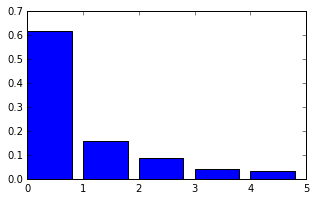

In [18]:
plt.rcParams["figure.figsize"] = [5, 3]

plt.bar(range(pca_result.shape[1]), eigen_values)
plt.show()

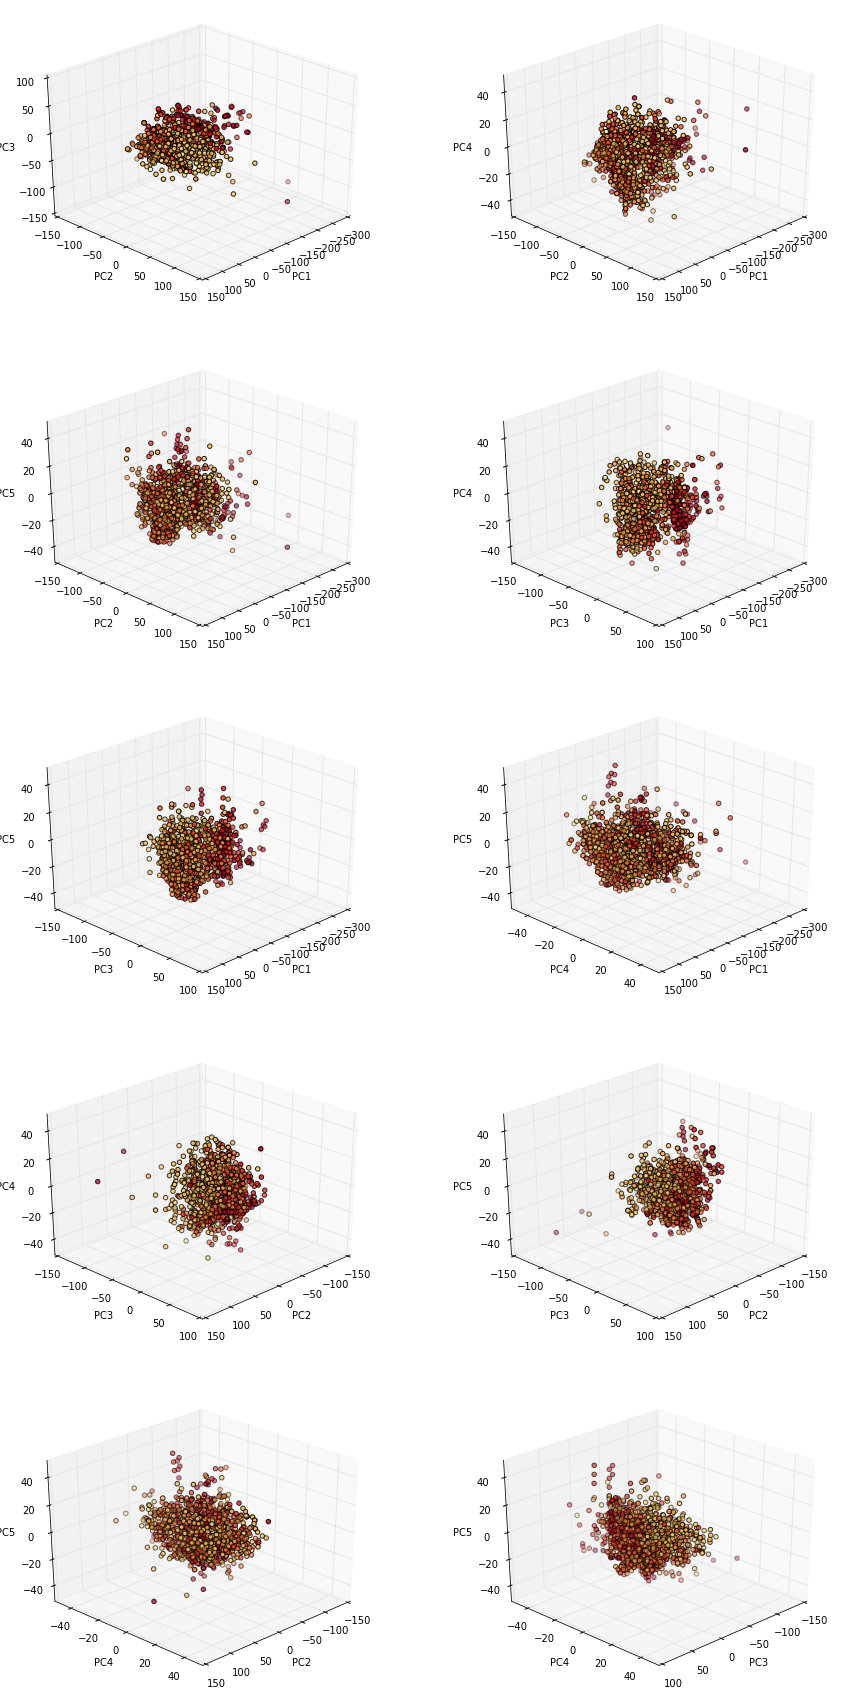

In [19]:
from mpl_toolkits.mplot3d import Axes3D
from itertools import combinations

combos = list(combinations(range(n_components), 3))

plt.rcParams["figure.figsize"] = [15, 30]
fig = plt.figure(len(combos) / 2)

for idx, combo in enumerate(combos):
    ax = fig.add_subplot(len(combos) / 2, 2, idx + 1, projection='3d')
    ax.scatter(
        pca_result[:,combo[0]]
        , pca_result[:,combo[1]]
        , pca_result[:,combo[2]]
        , c=data.ic50
        , s=20
        , cmap='YlOrRd' # red are the compounds with higher values of pIC50
    )
    ax.view_init(elev=30, azim=45)
    ax.set_xlabel('PC%s' % (combo[0] + 1))
    ax.set_ylabel('PC%s' % (combo[1] + 1))
    ax.set_zlabel('PC%s' % (combo[2] + 1))

plt.show()